# Adaptive exponential integrate-and-fire neuron model

The adaptive exponential integrate-and-fire (AdEx) model is described by the following set of equations:

$
C \frac{\mathrm{d}V_m}{\mathrm{d}t} = g_L\left(E_L - V_m\right) + g_L\Delta_T\exp\left(\frac{V_m - V_T}{\Delta_T}\right) + I_{ext} - w\\
\tau_w \frac{\mathrm{d}w}{\mathrm{d}t} = a (V_m - E_L) - w\\
\mathrm{if}\ V_m \geq 20\,\mathrm{mV},\\
V_m \rightarrow E_L \\
w \rightarrow w+b
$

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
cell_type = 'regular_spiking'
# cell_type = 'adapting_spiking'
# cell_type = 'initial_bursting'
# cell_type = 'regular_bursting'
# cell_type = 'delayed_regular_bursting'
# cell_type = 'fast_spiking'
config_file = os.path.join('configs', f'{cell_type}.json')
params = json.load(open(config_file))

In [3]:
C       = params['Cm'] * 1e-12
gL      = params['gL'] * 1e-9
EL      = params['EL'] * 1e-3
VT      = params['V_th'] * 1e-3
Vpeak   = params['V_peak'] * 1e-3
Vreset  = params['V_reset'] * 1e-3
DeltaT  = params['Delta_T'] * 1e-3
tauw    = params['tau_w'] * 1e-3
a       = params['a'] * 1e-9
b       = params['b'] * 1e-12
I0      = params['Ie'] * 1e-12
tarp    = params['tau_arp'] * 1e-13 if 'tau_arp' in params else 0
print('The input resistance of the cell is approximately {:.1f} MΩ.'.format(1/(gL+a)*1e-6))

The input resistance of the cell is approximately 83.3 MΩ.


In [4]:
def AdEx_fun(x,I):
    Vm,w = x
    return np.array([
        (-gL*(Vm-EL) + gL*DeltaT*np.exp((Vm-VT)/DeltaT) + I - w)/C,
        (a*(Vm-EL)-w)/tauw
    ])

In [5]:
dt = 0.01e-3
tstim = 200e-3
tbefore,tafter = 50e-3, 150e-3
tend = tbefore+tstim+tafter
t = np.r_[0 : tend : dt]
n_samples = t.size
Ie = np.zeros_like(t)
idx, = np.where((t>=tbefore) & (t<=tbefore+tstim))
Ie[idx] = I0
X = np.zeros((2,t.size))
X[0,0] = EL
t_last_spike = -1000
for i in range(n_samples-1):
    if t[i] - t_last_spike < tarp:
        X[:,i+1] = X[:,i]
    else:
        X[:,i+1] = X[:,i] + dt * AdEx_fun(X[:,i], Ie[i])
    if X[0,i+1] >= 20e-3:
        X[0,i] = 10e-3
        X[0,i+1] = Vreset
        X[1,i+1] += b
        t_last_spike = t[i]

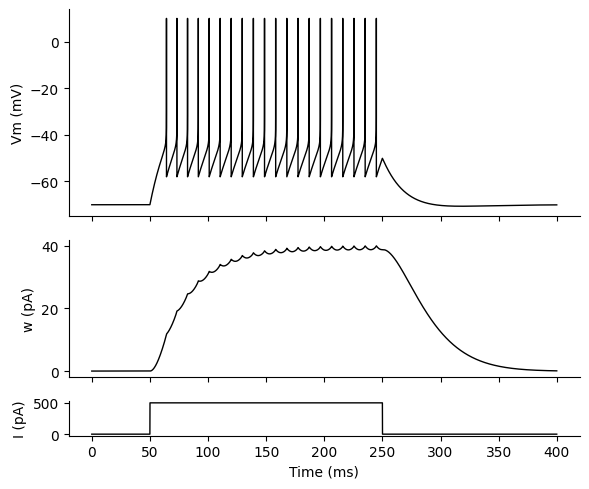

In [6]:
Vm,w = X[0],X[1]
fig,ax = plt.subplots(3, 1, figsize=(6,5), sharex=True, height_ratios=(6,4,1))
ax[0].plot(t*1e3, Vm*1e3, 'k', lw=1)
ax[0].set_ylabel('Vm (mV)')
ax[1].plot(t*1e3, w*1e12, 'k', lw=1)
ax[1].set_ylabel('w (pA)')
ax[2].plot(t*1e3, Ie*1e12, 'k', lw=1)
ax[2].set_yticks([0, Ie.max()*1e12])
ax[2].set_ylabel('I (pA)')
ax[-1].set_xlabel('Time (ms)')
sns.despine()
fig.tight_layout()